In [11]:
import pymc as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az
plt.style.use("seaborn-darkgrid")
np.set_printoptions(precision=2)
pd.set_option("display.precision", 2)

/var/folders/zz/hwfwgc3s6wdfpwyj5z1s5y4m0000gn/T/ipykernel_91995/1970589303.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-darkgrid")


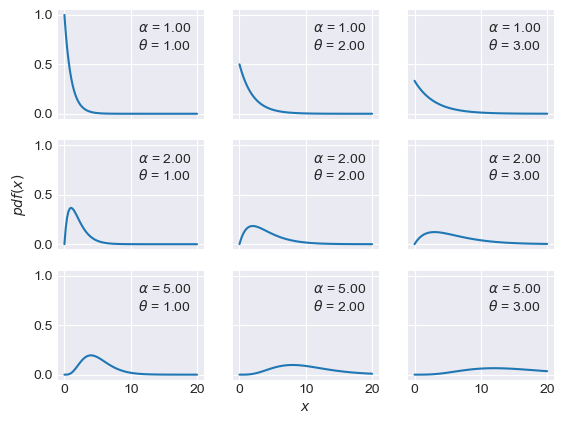

In [4]:
rates = [1, 2, 5]
scales = [1, 2, 3]

x = np.linspace(0, 20, 100)
f, ax = plt.subplots(len(rates), len(scales), sharex=True, sharey=True)
for i in range(len(rates)):
    for j in range(len(scales)):
        rate = rates[i]
        scale = scales[j]
        rv = stats.gamma(a=rate, scale=scale)
        ax[i,j].plot(x, rv.pdf(x))
        ax[i,j].plot(0, 0, label=f"$\\alpha$ = {rate:3.2f}\n$\\theta$ = {scale:3.2f}", alpha=0)
        ax[i,j].legend()

ax[2,1].set_xlabel("$x$")
ax[1,0].set_ylabel("$pdf(x)$")
plt.savefig("img401.png")

### 人口データの生成
- 線形回帰を行うデータを作る

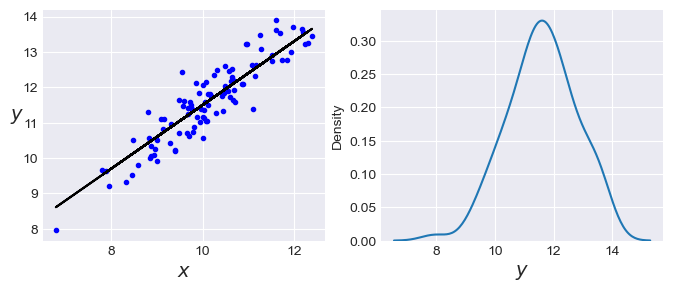

In [8]:
np.random.seed(314)
N = 100
alfa_real = 2.5
beta_real = 0.9
eps_real = np.random.normal(0, 0.5, size=N)

x = np.random.normal(10, 1, N)
y_real = alfa_real + beta_real * x
y = y_real + eps_real

plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.plot(x, y, "b.")
plt.xlabel("$x$", fontsize=14)
plt.ylabel("$y$", fontsize=14, rotation=0)
plt.plot(x, y_real, "k")
plt.subplot(1,2,2)
sns.kdeplot(y)
plt.xlabel("$y$", fontsize=14)
plt.savefig("img403.png")

In [39]:
with pm.Model() as model:
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=1)
    epsilon = pm.HalfCauchy("epsilon", 5)

    mu = pm.Deterministic("mu", alpha + beta * x)
    y_pred = pm.Normal("y_pred", mu=mu, sigma=epsilon, observed=y)
    # y_pred = pm.Normal("y_pred", mu=alpha+beta*x, sigma=epsilon, observed=y

    start = pm.find_MAP()
    step = pm.Metropolis()
    trace = pm.sample(draws=11000, step=step, start=start, tune=1000, chains=1)

/var/folders/zz/hwfwgc3s6wdfpwyj5z1s5y4m0000gn/T/ipykernel_91995/3689488610.py:12: FutureWarning: The `start` kwarg was renamed to `initvals` and can now do more. Please check the docstring.
  trace = pm.sample(draws=11000, step=step, start=start, tune=1000, chains=1)
Sequential sampling (1 chains in 1 job)
CompoundStep
>Metropolis: [alpha]
>Metropolis: [beta]
>Metropolis: [epsilon]


Sampling 1 chain for 1_000 tune and 11_000 draw iterations (1_000 + 11_000 draws total) took 2 seconds.
/Users/hiroakimatsumoto/miniforge3/envs/pymc_env/lib/python3.11/site-packages/arviz/data/base.py:221: UserWarning: More chains (11000) than draws (3). Passed array should have shape (chains, draws, *shape)
  warnings.warn(


arviz - WARNING - Shape validation failed: input_shape: (1, 11000), minimum_shape: (chains=2, draws=4)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.89,0.44,1.14,2.70,9.50e-02,7.00e-02,22.0,65.0,NaN
beta,0.96,0.04,0.88,1.03,9.00e-03,7.00e-03,22.0,68.0,NaN
epsilon,0.47,0.04,0.41,0.54,1.00e-03,1.00e-03,1447.0,1606.0,NaN
mu[0],11.66,0.05,11.57,11.75,1.00e-03,1.00e-03,4132.0,4437.0,NaN
mu[1],10.01,0.09,9.86,10.17,1.60e-02,1.20e-02,29.0,108.0,NaN
...,...,...,...,...,...,...,...,...,...
mu[95],11.07,0.05,10.98,11.18,6.00e-03,4.00e-03,89.0,603.0,NaN
mu[96],13.11,0.08,12.95,13.26,1.40e-02,1.00e-02,35.0,117.0,NaN
mu[97],9.45,0.11,9.25,9.64,2.20e-02,1.60e-02,25.0,96.0,NaN
mu[98],12.15,0.05,12.06,12.26,4.00e-03,3.00e-03,156.0,985.0,NaN


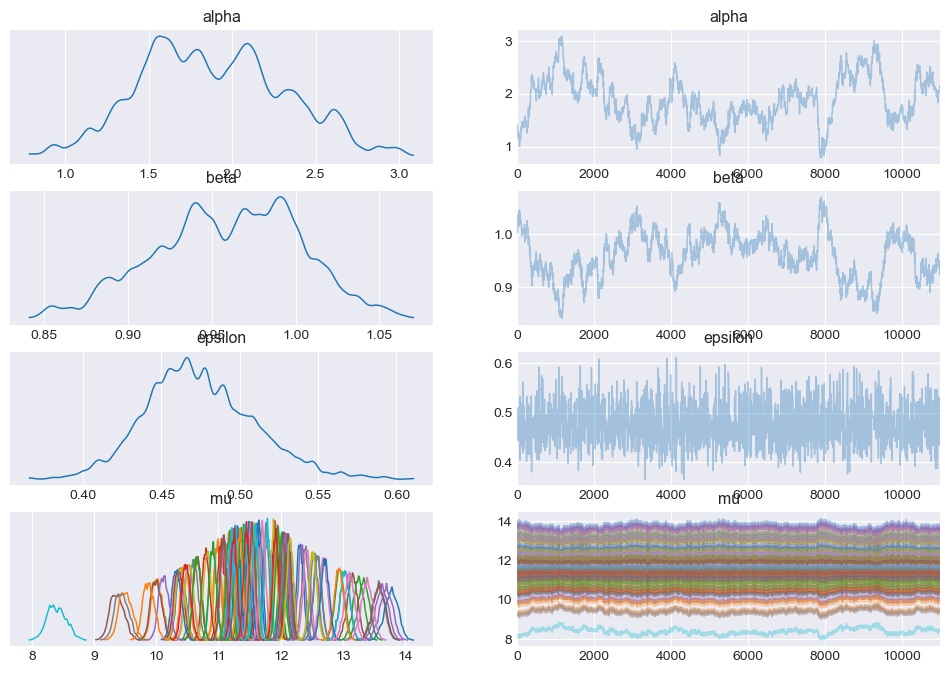

In [40]:
df = az.summary(trace)
display(df)

az.plot_trace(trace)
plt.savefig("img404.png")


In [42]:
# trace.posterior["alpha"][:,1000:]

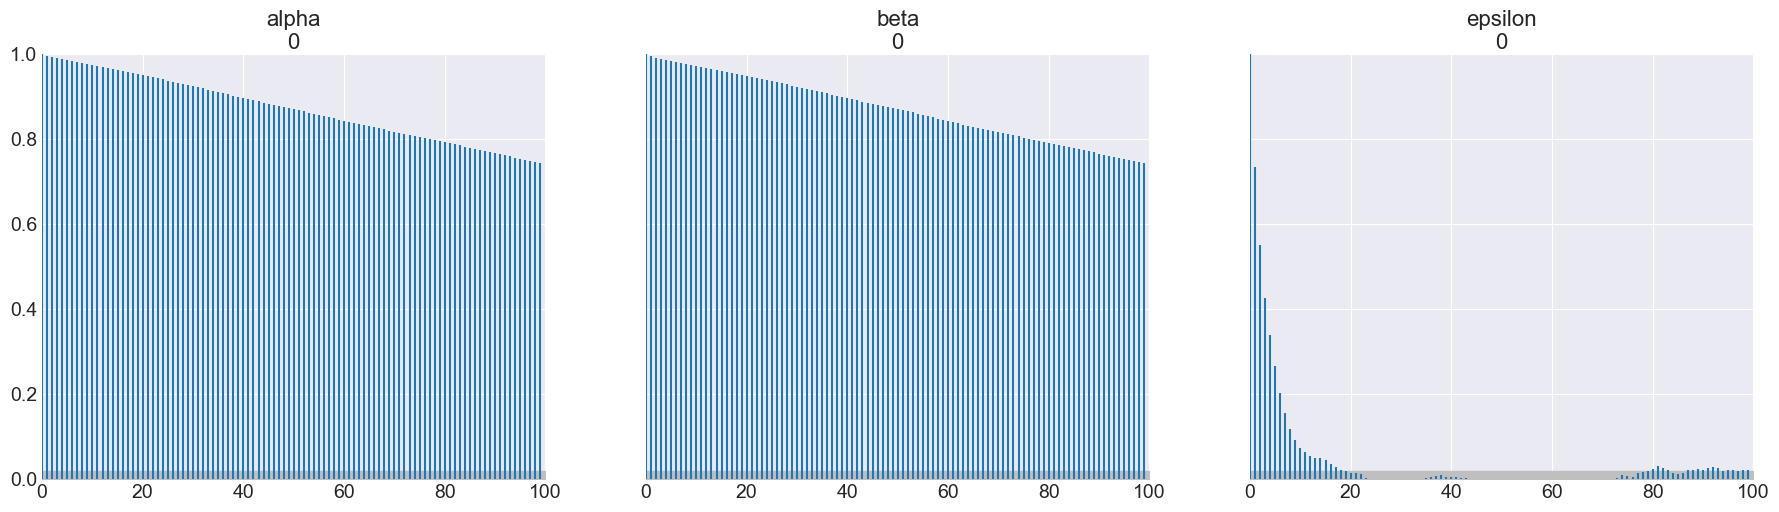

In [47]:
varnames = ["alpha", "beta", "epsilon"]
pm.plot_autocorr(trace, varnames)
plt.ylim([0, 1])
plt.savefig("img405.png")